# Мешок слов и классификация текстов

Одна из базовых задач машинного обучения - это классификация (отнесение объекта к одному из заранее заданных классов). Классификация очень хорошо подходит для задач NLP, так как многие практические задачи можно свести к классификации (определение спама, определение тональности, определение намерения пользователя и т.п.).

Есть очень много алгоритмов МО, которые применимы к NLP. У каждого свои плюсы, минусы и особенности, которые по-разному проявляются на практике. 

За одно занятие разобрать все важные алгоритмы не получится, поэтому сегодня поговорим про алгоритмы, которые из-за простоты использования удобно применять в качестве начальной базовой (baseline) модели. Более сложные алгоритмы (бустинги, lstm, трансформеры), практически всегда, будут работать лучше, НО помимо качества в практических задачах часто есть много других требований и ограничений (скорость, память, интерпретируемость и тп), которые могут перевесить разницу в точности. 

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

from IPython.display import Image
from IPython.core.display import HTML 

В этой тетрадке мы рассмотрим задачу определения токсичных твитов. 

In [89]:
data = pd.read_csv('labeled.csv')

In [90]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


В определении тональности токсичных текстов обычно значительно меньше. Дисбаланс классов может сильно влиять на качество модели, но сделать с ним практически ничего нельзя (можно пробовать выкинуть часть мажорного класса) 

In [91]:
data.toxic.value_counts(normalize=True)

0.0    0.66514
1.0    0.33486
Name: toxic, dtype: float64

Для того, чтобы понять качество обученной модели нам нужно разделить данные на обучающую и тестовую выборку. Оценивать модель нужно всегда на данных, которые модель еще не видела! 

In [92]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [93]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

### Векторизация текста

Перед тем, как рассматривать алгоритмы классификации, нужно разобраться с тем, как мы будем подавать наши тексты на вход разным алгоритмам. Все они работают с числами и текст, соответственно, тоже нужно превратить в число. А точнее в набор чисел - вектор. 

Самый простой способ векторного представления текста называется "мешком слов" (bag-of-words). Мешок тут не какой-то технический термин, а метафора. В таком способе векторизации никак не учитывается порядок. Слова как бы складываются в "мешок" и перемешиваются. 

Если более формально, то для того, чтобы векторизовать некоторый набор документов (=текстов) мешком слов нужно:  
а) составить словарь всех уникальных слов, встречаемых в этих документах  
б) посчитать частотность каждого слова в каждом из документов   
в) зафиксировать порядок слов в словаре и составить для каждого документа вектор размерности N (N - размер словаря), где по индексу i стоит частота слова w_i в этом документе. 

Вот картинка для наглядности:

In [94]:
Image(url="https://i.ibb.co/r5Nc2HC/abs-bow.jpg",
     width=500, height=500)

Обратите внимание на то, что порядок колонок (слов) в этой таблице не соответствует порядку слов в текстах.

На картинке выше частотность записана в абсолютных значениях. Лучше использовать относительную частоту, чтобы тексты разной длины были сопоставимы друг с другом.

In [95]:
Image(url="https://i.ibb.co/47bRcVy/bow-normalized.jpg",
     width=500, height=500)

CountVectorizer в sklearn векторизует как раз таким образом

In [96]:
vectorizer = CountVectorizer()
# в векторайзер нужно засовывать тексты строками (токенизация там встроена)
X = vectorizer.fit_transform(train.comment)

### TF-IDF

Еще вместо нормазиванных частот можно использовать tf-idf (term frequency - inverse document frequency). 

Кратко про tfidf на картинке

In [97]:
Image(url="https://miro.medium.com/max/1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg",
     width=600, height=600)

Tfidf позвозволяет оштрафовать слова, которые встречаются в большом количестве документов (грубо говоря это стоп-слова, но специфичные для корпуса) и поднять важность слов, которые встречаются часто в небольшом количестве документов. Если слово встречается во всех документах, то соотношение $N/df_x$ будет равно 1, а логарифм от 1 - 0. Чем меньше $df_x$, тем больше будет $log(N/df_x)$

А в вектор таким образом добавляется информация обо всем корпусе. Обычно для модели это оказывается полезно.

In [98]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train.comment)

Векторайзер возвращает результат в виде матрицы

In [99]:
X.shape
# первая размерность - количество документов
# вторая размерность - количесто слов в словаре

(12970, 63944)

Слов получается в 5 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы признаки <= документы), а те что смогут будут обучаться сильно дольше. И учитывая, что большая часть слов встретились по 1 разу, они все равно никак не помогут.

In [115]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.4)
X = vectorizer.fit_transform(train.comment)

In [116]:
X.shape

(12970, 3366)

В словаре у нас 7,5 тысяч слов  и каждый документ мы описываем вектором такого размера. В этом векторе положительными будут значения, соответствующие словам, которые есть в этом тексте, а нулевыми - те значения, которые соответствуют словам, которых в тексте нет.

**Нулевых значения будет значительно больше!**
Поэтому для эффективности в sklearn такие матрицы хранятся в специальном sparse (разреженном) формате.

Просто взять и посмотреть на матрицу не получится.

In [119]:
X # 174091 из 43657020 позиций в матрице ненулевые (это меньше 1 процента)

<12970x3366 sparse matrix of type '<class 'numpy.float64'>'
	with 174091 stored elements in Compressed Sparse Row format>

Некоторые алгоритмы не умеют работать с разреженным векторами и такую матрицу можно привести в обычный dense формат (X.todense()) НО будьте острожны с большими матрицами - они будут занимать в памяти ОЧЕНЬ много места.

### Косинусная близость

Между получившимеся векторами можно посчитать близость используя косинусное расстояние. Есть геометрическое объяснение косинусного расстояния: угол между двумя одинаковыми векторами равен 0, а косинус 0 - равен 1; угол между перпендикулярными векторами векторами равен 90 градусов, а косинус - 0; угол между векторами направленными в противоположные стороны равен 180, а косинус -1. 

Картинка для примера:

In [120]:
Image(url="https://i.ibb.co/GJBNdPH/image.png",
     width=500, height=500)

Допустим в нашем словаре 2 слова: Hi и Mark. На графике изображены три текста: "Hi", "Mark", "Hi Mark". Между Hi и Mark нет ничего общего, они перпендикулярны, поэтому их близость равно 0, а между Hi Mark и Mark уже есть общее, поэтому близость будет ненулевая. 

Но геометрическое объяснение не очень подходит для понимания косинусной близости для векторов текстов. Вектора текстов обычно сильно длинее 2 и визуализировать такое не получится. Поэтому давайте лучше посмотрим на алгебраическую интерпретацию.

Формула вот такая:


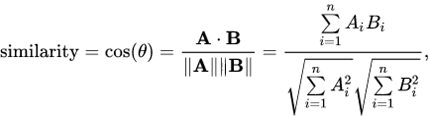

In [121]:
Image(url="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAa0AAAB1CAMAAADKkk7zAAAAaVBMVEX////l5eXBwcErKysAAAD6+vqoqKg5OTnz8/OEhIS+vr7u7u739/fa2trT09OhoaFPT0+Ojo7KyspaWlpkZGS4uLhqamqxsbGZmZlvb29+fn4hISEQEBAmJiZ0dHQ+Pj5HR0cYGBgyMjL2v28PAAARmUlEQVR4nO1dCXucKhQFBTcUxA3cl///Ix/gjEvGNpklyWvi+dqkmZmg9cjl3IUrACdOnDhx4sRLEJo/J/4JRDJKWI6/+zROfASkKl0Z9Ml3n8eJj4A4ZQaIa333eZz4EEgvQDJ6pyn8JxA1EPtpFH33eZz4ALAzAC+rOPzuEznxAeAgByDxz3XrxIkTvxMEQhhdADVOXfg/RpCmlX9BVaZx8VYXErr7MfTCUP/9ujM8sYJOqKQXWDIdkb9/Pyz77Y84kdyXDuMyOSfhNyAfx40WTAZ3z0KOpu1sw0mGms7hXTs6J11fD1yhfsMHTIPtu7BA7t4Ls8ZCf8ubfm8iT3wJSIwKb/0xEds3nWGw96xIxPW3YDzZ+hbQtmF/eisT8bijD5SNmXwl8k+l8S1wmvo4WYK5D7I9W9EwJR6kfOjOMNX3AHcoPrz2QUywj+T2pXycJJNpy0+N8V0gA6rI7cuwVBbSR5X+t8Xn1yTKckc4aa/tocUOfuvEZyOpx4NsiVMzwdKZLZHOk6lsjGHMGz0b2WkOvwVxdjtLoriqOj9FRrFfJEXUT0YKBrVLAT6t4bdAZAeTRBqaLBQD4Ak56/WgmeeYj0pMEn6K+G+AlR5cdmcw081CgyKpyuaIFDOaw5P1lADBJv/21058MpIs3/xkOMJWNWkvDLKyaStBnDjXL/o2cruyKlxNLxWx+MOIJz4NJN1q9MQwhy0upXoZSs4YzwEfwhDgoOqqMssqmZvgB09PkfHVwNmWLDoc5fth0R2U2KSc/tqFixwrrJAYfFqYB/Nq81Me20enEZWpcyMaSZo6v3VyifQwBRHyfojjwXXTrAoO3n8afHKsYAbjWY2qow+FiTjwx5JfSxYeUH8UGMB5ZyM0+FXnIvsTwj3J1A69wdDbNWqms7z6A0hG1Pxh7pTIxMipi+rX15BFQjhXCIXgjKx/ACVCuzTTClKgRl6+8y8+qxOHIG3WoPqwsnlhK0Xj6d/8L8BqGiMkj8yQZsuHMKrGkR9OvqeAq+0dgCNxTt93gYcsFM2xzlBsITdN4wbdVI+94sjddi0kvJhef4yfhkTph9BGzRoBgv71ntdzq1T62onr9BME2246Y8rb1x/ip6EcpRA9Qtli6nI0Xa6jZsvUTQiE0lcrtoTJvVcg6xcf4ecBtqNyeCaExiWSY/K2BleVAShC7YttYciZHQLJZzhqcp1svQs5OollWUpn8GXyLEvYwlaCkP3i4IFn8SEE1zp4fSv8BrbCzT1P7q9V6DPzLVc644CO2Tv2NJndoyf4J3iTWh7pzBX9P7CF6adHs6B/CUPQHIOI53//9BtEQ4saPWm6VnnIdr9X6aFvN8pC2m3doPb1mxcDGzqhuED/J9hXsOVxefsizn0CrGk8uiMJZy9bsT0/M2NFZVeqYznZXXmE0MotK1cD0EBZw/wt1ZF6dw67WvT17pZwfQq8GcRTV2VAX7BFEjb17SWC8egAT+rCgtvTHE31t3iFJrZcc2yYxV7eK8vSZf9MeQkJdroFR9T6fFMEvKq6vfFC1qlzge4RW1FnAged8/yxSVfqb5i3CYhiNbny/lNyGz8I4ZGVwPpF2B+xBTxNVpS+IPKW2MZ20DbTofRUR/SK50f9mQikk1AcJQkEUH0JBYMAm+SZelHP6pktyLjOnWH9mSjx1JRXqwApRk4j/VqivlL15S8H8gIpjZGAjmPMR+hwJ4m0jNIqEHNdF5mb6rvKff0K8xMQplxIm3tdbSehdO2u5IUrO99vfUD8VutTw1Zgp3k3CLWK2W3aTWVSjHEU8hq5Q0XEUNuVx9rmqLz4ChqnTjclSqTFjpP6ykuJufBtBkhm6/cjV+s6ZvYWOtPZzOAIeQPVuuErk9ZYgDhoikI6tsyL+ilUnnrjXNhiKFNSWQmLkKM4H1KI41aJoapmEAKPTq26vJN/IStI4xUX8RLGamhdwe/UCcbJJDF3FWOZBDA13pLVjGkajyZIJNyrgRWbke6TivcAs2E5ylD9f9PvQZMFEEYAd3o/ZqQ4AbC29dKhk0V5c51bJNAOjf6MUC6mdmALxRaQ7awH/CYH0RLiDuEGF+PoNEo+EOGRelA/ebFNeNNZUPn/0WBWKQd1hFita5Rme/UnvIOhAEm0Vn8ewUI/2RxlqcaB1msO8zQW2enFqBkzAsJSM0H1vj1YT1q8a7bEwhagVe+OOlPuXPZBG7Z4Pbs3SZ2B6k9bzjRwZar1le9r/AGvaCjsUVN3an65mi3s63lszUXjef3XLBGNW/sVqMu/HQWI/jWHeRqbcFreTWq2XNjSATXDFin2bAmdbaj0Z1gt92xF2v6lo5Utshtu7/3wytbM68JWotRGNjZcWULNUFjpA/pz5cTKFtzcYsl1VcTwRViWWbiecLD40OH7A3wNltO0ND3FBHA5JvpSLmylO7aiwVZvF7UMsFOzC1vRzFanJw1ren+x95T7Ky7T2FhCJTPhqNN1pK8hFwDTOFNsGQ/BryGg7ny359N13bKqdST+aS3KwnxzGPa/XLcwVQZaKCGGearmkq4YShBXtmq0jSWk+hIzXSs0KGs1UUD7tpKENbMlzJQvq0hyQKWnA+nRGvLB3gaXVYAMtpIojGOmb4tk5F7WKxegVNO6M+lW0VLcXYKyrE3+MtQnINwc5X9ZtIT56GOQt7FfDQmJ2yZ2pIvq0hpQU7CiaQbObdRy6jZNkTj1wLvUbjlrUZtZgJYjmnItE4u56LIb3rnzo9juulKtkNItK9cHXlmnfpZGelOanuqwjLP4MkbVP+lv/TORq49C93kItRgKAqLTFIRgXYTsYf0l9HQxcmgqkvXPxrLDkCrxbT6p7nnzTb2ceObi+O+GoDxqPqtWHcvSI0Qwys2qRntj90iQXG5rGL+f2dAaNVjduw09kCrvXr8T5rpI9uiXo0Tpykc3keI78IIhLmNgWL4oYpCoxSl73J/VlngHZ3o/Tpiq461lFliuDaMDP8QmDk5iDIiSK2EgRG5SGtZcDu8xBqj/0CoYOYw5HwcTB1sm7xviEvhRovxFe5Q5cuQzxV803vm9XvGBMOGerbxeawkDH2OTLyPaT1Q3AhzGRvkpjcJoHHjC5KNslZPbux/HlN4ehdV3DKDQC30jhtmrGpjTePCfElIi3d438mAP7w00UytbKULs+p/ZsQW13sTURjYOsceR8ee8x9lSVz+8C7dDSP7IEPCwVvIhPLvdGTsbbzj50HXcsRW1CA3X++WWLQAnZHQnbU2PrGfYelreE/+xtMX/SDjhu2+cHVuVzuZfPYgNW6Fh7IVsJc8vHvQ3bg3fsoXtMlv3LKxsDZb6q19SbNnalXJQo93vx9mS8mlhJn5jf6ctW05jJSO69hfZsQUb/ZJia6yqSjmRvjYoj7NV3lfgcwR5uB3vh2PLVjp4YFj2LPyBLc65P4ypbrn5OFvx88Ev/vIquX8AG7YipcsJX2oJj9ky61Y0oDZ/CVshhATCB8yi519TFTpoTB4Z4h/Ehq2qyaqqXHTGRmXAN2yFSsJnT7BFi6skZFlfVfEDRXrRtXRSuS1xxoffsYqtbOEplgrZdc/CThPu2cKKrfgJthx+lYS+0yageuBSB9cEOwj4IIH/O1pmrGyJ0dyttL7ojI0lTC5sRUoTms/EpiT+Ybb8JZ5AeBqCmN3vBMl12ZLK1U5/h+a4spXzqdFVj4lauFCmU2A3bHlO1aBGq4weNTpO8jBbG5ERc+WT/73I6xAbkVFkAPbsgbL/fw9Xtvxpcm2BgTO4vTvpcPDGEnqGLZjq4N5k23ZfmJXmYbbWrBBpLMBcIe42hXyJ2oR9BcTg57/BFO7jhFvsI0/NwSceZQuufe2ilABa+nfPC8jXegh1kpH/XID1X8FH2Tra8vEoW9b97NwM8T+uf/tE6IxJ/Be2tBPc6WzJwScezZj4zh2GLzx0pdhdvjH8KdRmyfz3FhbHmFuaLa53RBx8wmQjH6jJmedyqBPrlxKO45yIBhHcPzi9WRJibz/EH/qJJbJyfob3rBfn4wU6UkyZgkmd5T/M9IdUiUXrfqtmRAbhlWQzJPe76oYTDM2d0tHMvT0/qUWGEqnSWYaoqio/pDzPLFmL/1Gm5J9CaBLBpEfT5VrzMusblL65nlTXLOvSkqi+acQKfR1vIQWq+TyErLKh3jwIJRRMmHcSDKqBgP640fyJd3FRCFY7biLxYnjTryjMdBGmJ4Ty12/YSiqT3KI92qZf03EpQSLFiJpJeSWTTxLmgWH4De7YZ4BfgvwS2RvrF6X7Pnr5pYOA+nx/szSKah4ir7ctp8Jis9VRIhP2TQ2fif2C3Yy/E8XVVSpQvLnjKd+uOjDuL53a8vS2DExeK+85cjcpZMhWXlNkbgUfZUQ5eGfXqEexVGbBnSEDu0dFskLOfR6oYuAmp790dSUZ2tYKrY1k8TQ/XS1WU4w4OUh+RYz+9cBrHZ1VN39IIicxdHRSBlhxFfC36xbhyz4cvXQdyT3LdFAgvC68sMiE+Ej914lbJJuHjvD98wUXeB0HFkp10tEe3PhtEWu06c4gmvqIcY5SpRTTSa1Xge7/ys+59RAcud7mYbZpALaBVSjDiFzd+SYI5kLyLfJqc+19dKtC9LLV8crvUhYCqpt83B/lP6HRbadC5KIDv5UMKXP8OZd2BLktQoYpqm6GCKe5FVWKzoeAPoVhF7SQR11f2VQURYoOW8KbX9ptxszb29yzVc8LlY+6c8F6APR61XbF+l518MCYKE4IJMlck09WVQ6vPPOdIJcH8Xh+eRJeaiq4nFfVvv8WLE/Epbs+r1V3u/rjzjDouYYturQgIFeSol0LKHbUODZF5rfYvKaVD5QS/GpwdBHdawWNfvX2eVuEp9p6YeqPqNRWcvmENc4N+UC+tW7iNjsXOn6DOsl51s7JIHiSdRfg4hZVm2VfbDf6hLO5gmWaKtOGgzLLMgkidiWDdPoJXBoyW3/L2kU6EkOtx4ssK8uy6MxDT4hzBuDvA4+bi3+6SX0mu2nBZmWHiefp3aKeecYN4dW1O5YV15de2htJGGXbAKCoZva9+Qk5lxnIpf1p++J/JAhn9sUrGhaRQYutlmf2kZNLHD+7/ovHl03vchEZsNs9sms6DAcK4Z5s3QMPkn68NE+8Xjkv89XtD4nes52IYqwPpTa97sb1Ilg0ZiKtZbqeX0aeHgJDQoVvj8c7d+PzQYX3IkZzw5VrcVKYotpuFQa7tccGoeJwcZE9WeYcn4PA1jV0hTlqJjWC7U6tXashjjdDQJsebFs+8TeUsyhcG9M6jMkrGGPO4ZUOfZstMkKYOC8Q1xoRnOyH0IniA1j2XWU7J4CeGCbicJCs+iuoXJWIhWJNB7uzRyZh4mfU0HwhxGh8q/je/aeb6UJtIxfkvcvQqd/vRmLr5AhZRAaI3iQIrXeFWxTrZmPrk1UAfNNaJTlLZV6FvqG7GttdaxAcdPa7rVhIafplrfWmV/9qhlXVZ/XFq5BqUbjZHr4voIUCvb8X2fSfFWsA3ot2pRyiOWjGf+IhdFoUro2R8jeZkvBPSf8Nci0K2RJ3St5IPdKebL0KrKnCNbkl8t4C1uWhQLo6m3yALQsN4bqZP2eZD5LLCLrUF9YnW69CMKYQpFdJKJKaAnJ9KFD4MbaiaYq8pYKGirhahyD6gVQnW68Cbe2IlkvcScZ7J+gjbMF0tKJqccCcYe8OnGy9ED2izioyXCcIxcWKfdQSeiVykrW/YJlFEfU3lrD9WwPpE3chRbRcpEVkC58sfc8xiPLmA42blCgMFpFBikzQpZOzB0g+FtEZtXgRKsTWCppQyq2vhPNcivfLk5QoDNadZLm/4zcRzBGnf/wisKbcLDThPgzhhfjwgT17WKPNVw8Ykx29oYfxJ3Z4/mWw2vq2DOM+0AF9xtN7T9wCTujg4WT3DVGgc9vcF2FA8klDFfooe/9TJ16BDD39rD2Gzp1YXwR/erq5aj6dYfYvAsuerj2yjrtFnHg94M3WnvuHeKDhw4l/Gv8BnCgeUlxeEn4AAAAASUVORK5CYII=",
     width=500, height=500)


В числителе (вверху) здесь скалярное произдведение - это такая операция с векторами, когда числа, стоящие в двух векторах напротив друг друга перемножаются, а результат складывается. 

В знаменателе (внизу) тут произведение длин векторов, а длина вектора считается как произведение корней из суммы квадратов значений в первом и втором векторах.

Вот пошаговая визуализация расчета близости для двух векторов с абсолютными частотностями.

In [122]:
Image(url="https://i.ibb.co/pb8ZCJT/tg-image-911960310.jpg",
     width=700, height=700)

Выглядит наверное сложно, но важно понять, что тут происходит. 

Вверху (скалярное произведение) по сути происходит поиск общих слов в первом и втором векторе (=тексте). Если слово есть в одном тексте, а в другом нет - то результат произведения будет нулевой. Если мы будет использовать не частотности, а какую-то метрику с возможным отрицательным значением, то скалярное произведение будет штрафовать пары значений с разными знаками (будет получаться отрицательное число и сумма будет уменьшаться). **Чем больше значение скалярного произведения, тем больше будет итоговая близость.**

Внизу - просто нормализация. Результат скалярного произведения может быть любым (отрицательным, положительным, большим, маленьким), деление на длину вектра приводит итоговую метрику в удобный интервал от -1 до 1 (а в нашем случае без отрицательных значений от 0 до 1). 

<!-- Почему тут не просто сумма? Потому что значения могут быть отрицательными и может получиться ноль. Для обхода проблемы с нулями часто используется корень из квадрата 
(почему не абсолютное значение - как я понимаю сложный математический вопрос, часто пишут что абсолютное значение сложнее математически, а квадрат проще) -->

Попробуем посчитать косинусное расстояние между настоящими текстами.

In [126]:
train.loc[2, 'comment']

'Так ведь там, где чёрные границы можно рекламу транслировать прямо во время фильма\n'

В sklearn есть косинусное расстояние и косинусная близость. Близость это просто единица минус расстояние, то есть расстояние между близкими векторами должно быть маленькое (0 если совпадают 1 - если вообще не совпадают), а близость наоборот (1 если совпадают 0 если не совпадают совсем).

Расстояние удобнее использовать, когда нужно отсортировать по близости, т.к в numpy по умолчанию сортируется по возрастанию.

In [127]:
# функция предназначена для расчета близости между массивами векторов
# и возвращает она тоже массив где каждая строчка это объект и первого массива, 
# а каждая колонка это близость до объекта во втором массиве

# в нашем случае в первом массиве у нас только 1 вектор
# поэтому мы можем взять первую строчку из получившегося массива
# метод .argsort вернет список индексов по возрастанию 
# возьмем первые три индекса и посмотрим что там за тексты
top_idx = cosine_distances(X[2], X).argsort()[0,:3]
top_idx

array([   2, 7185, 1143])

In [128]:
# первым нашелся этот же вектор
# а дальше уже не настолько близкие но все равно есть сходство
train.loc[top_idx, 'comment'].values

array(['Так ведь там, где чёрные границы можно рекламу транслировать прямо во время фильма\n',
       'Дак скоро и кинотеатры додумаются рекламу вставлять не только перед фильмом, а и во время фильма.\n',
       'Прямо как в полтоРашке'], dtype=object)

Мы векторизовали обучающую выборку, осталось векторизовать тестовую

Векторайзеры в sklearn имеют три основных метода **fit**, **transform** и **fit_transform**. 

**fit** - собирает словарь и статистики по текстам,   
**transform** - преобразует тексты в векторы, на основе уже собранного словаря.  
**fit_transform** - делает сразу и первое и второе (быстре чем 1 и 2 по очереди).

Для теста нам нужно векторизовать тексты тем же словарем, для этого вызовем метод .transform

Повторим еще раз векторизацию и достанем отдельно целевую переменную.

In [136]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.3)
X = vectorizer.fit_transform(train.comment)
X_test = vectorizer.transform(test.comment) 

In [137]:
X.shape, X_test.shape

((12970, 3365), (1442, 3365))

In [138]:
y = train.toxic.values
y_test = test.toxic.values

In [139]:
# ! Называть матрицу с признаками X, а вектор с целевой переменной y - стандартная практика. 
# ! Если вы сделаете наоборот, то сильно запутаете меня в домашке 


Интуитивно кажется, что bag-of-words сильно упрощает - порядок слов ведь очень важен для текста (целое больше суммы отдельных элементов, синергия, эмерджентность и все такое)! Однако на практике BOW работает необъяснимо хорошо. Начать решать практически любую классификационную нлп задачу лучше всего с мешка слов и простого алгоритма классификации. Это хорошее базовое решение, с которым удобно сравнивать более сложные решения и к тому же есть шанс, что уже такого базового решения будет достаточно для практического применения.


## Алгоритмы классификации

Теперь попробуем обучить модель. Рассмотрим 5 алгоритма, которые можно попробовать прежде чем переходить к чему-то более сложному: KNN, Logistic Regression, Decision Trees, Naive Bayes, RandomForest.

Кратко идея этих алгоритмов:

1) **KNN** - это предсказания класса текста по близости к другим текстам, для которых известен класс. Выше мы считали близость между текстами косинусным расстоянием - в KNN делается то же самое (но метрика может быть другая), только рассматривается топ-K ближайших текстов. В KNN таким образом нет никакого обучения - просто запоминание тестовой выборки и сравнение с ней при предсказании.

На графике можно нарисовать зоны, которые будут соответствовать классам для выбраного параметра K. 

In [9]:
Image(url="https://www.researchgate.net/publication/321751429/figure/fig2/AS:570779261562880@1513095788768/Visualization-of-KNN-model-with-K-value-set-to-be-5.png",
     width=500, height=500)


2) **Логистическая регрессия.** Предсказание с помощью обученной модели логистической регрессии - это по сути взвешенное средние чисел во входном векторе и приведение получившегося числа в интервал от 0 до 1 с помощью специальной функции. Если получившееся значение больше 0.5, то считаем, что этот текст "токсичный", а если нет, то "нейтральный" (но можем подобрать и другие пороги).

Коэффициенты подбираются на обучающих данных (это и есть обучение). Можно сказать, что в итоге для каждого слова находится показатель токсичности. Если в тексте будет много слов с высоким показателем токсичности, то весь текст будет отнесен к токсичному классу. Однако показатель токсичности не равно вероятность токсичности - он может быть равен любому числу (например, 0.282, -4815162342, 666.13) Интерпретировать значение показателя можно только по отношению к другим значениям.

Если в нашем векторе два числа, то коэффициенты обученной модели будут являться уравнением прямой, которая разделяет объекты на классы.

In [6]:
Image(url="https://www.researchgate.net/publication/325813999/figure/fig5/AS:638669773893635@1529282148432/Classification-decision-boundary-using-logistic-regression-The-blue-area-corresponds-to.png",
     width=700, height=700)


3) **Дерево решений** - это просто много вложенных if else. В процессе обучения подбирается такая серия условий типа "тфидф этого слова больше 1.23" или "частотность слова_а больше частотности слова_б", чтобы в итоге получалось предсказать правильный класс текста. Плюсом деревьев решений является их интерпретируемость - для каждого предсказания можно вывести цепочку условий, которая привела к такому выводу. 

Каждое условие в дереве разделяет пространство пополам, поэтому график решающего дерева будет состоять из четырехугольников.

In [7]:
Image(url="https://paulvanderlaken.files.wordpress.com/2020/03/readme-titanic_plot-11.png",
     width=700, height=700)

4) **Наивный байесовский классификатор**. НБ классификатор принимает решение по вероятностям, рассчитаным на обучающем корпусе. В частности нужно два типа вероятности:  
а) вероятность встретить конкретное слово в классе А и Б (токсик и нетоксик в нашем случае);   
б) вероятность каждого класса. 

Эти вероятности расчитываются по частностям. Например, количество токсичных документов со словом, поделенное на общее количество документов с этим словом - это вероятность встретить слово в токсичном классе, а количество токсичных документов, поделенное на общее количество документов - это вероятность токсичного класса.

Можно сказать, что в наивном байесе ничего и не обучается, а просто считаются статистики. При предсказании для каждого класса перемножаются соответствующие вероятности слов, присуствующих в тексте, и класс набравший большую оценку выбирается. 

Наивным такой классификатор называется, потому что делается предположение, что слова в документе не зависят друг от друга. Это конечно не так, многие слова появляются в тексте вместе не случайно. Допустим, мы рассматриваем тексты на английском. У нас могут быть тексты про яблоки (apples), про компанию Apple, и тексты про Нью-Йорк (Big Apple). После нормализации в словарь во всех трех случаях попадет "apple" и вероятность будет считаться по всем типам текстов. Но возможна такая ситуация, что тексты про яблоки нейтральные, про компанию - негативные, а про Нью-Йорк - положительные. Если бы мы считали совместные вероятности слов, то мы смогли разделить эти типы и делать более точные предсказания. Но это сильно сложнее, а наивный байес работает достаточно хорошо и так. 

5) **RandomForest** - это N деревьев решений, объединенных в один большой классификатор (лес). Такие классификаторы называются ансамблями. Ставить RF в один ряд с алгоритмами выше наверное не очень корректно - RF сильно сложнее и мощнее, но на практике его использование в sklearn никак не отличается, нужно только немного разобраться с основыми параметрами. 

Для каждого отдельного дерева в RF используется случайная подвыборка обьектов (текстов) и признаков (слов), чтобы деревья не получались одинаковыми. Поэтому алгоритм и называется случайным лесом. Отдельные деревья решений могут быть очень слабыми, если пробовать применить их самостоятельно, но вместе они дают очень хороший результат. 

In [13]:
# суть Random Forest
Image(url="https://www.meme-arsenal.com/memes/4050e1d63ea961e4549d59740c952bf5.jpg",
     width=500, height=500)

### Fit, predict

У алгоритмов в sklearn стандартный интерфейс - есть функции fit, predict и predict_proba (если классификатор выдает вероятности)

In [158]:
clf = LogisticRegression(C=0.1, class_weight='balanced')

In [159]:
# fit обучает модель
clf.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced')

In [160]:
clf.classes_

array([0., 1.])

In [161]:
# предикт предсказывает классы
preds = clf.predict(X_test)

### Метрики

#### Меры качества бинарной классификации 

При сопоставлении предсказаний модели с правильными (истинными) ответами составляют вот такую таблицу

<table>
  <tr>
    <th colspan="4">правильные <br>ответы</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>positive</td>
    <td>negative</td>
  </tr>
  <tr>
    <td rowspan="2">предсказания <br>модели</td>
    <td>positive</td>
    <td><span style="color:green">$tp$</span></td>
    <td><span style="color:red">$fp$</span></td>
  </tr>
  <tr>
    <td>negative</td>
    <td><span style="color:red">$fn$</span></td>
    <td><span style="color:green">$tn$</span></td>
  </tr>
</table>


$tp$ - это $true\_positive$, количество истинно положительных предсказаний модели (т.е. модель считает, что текст токсичный и он на самом деле токсичный)

$fp$ - это $true\_positive$, количество ложно положительных предсказаний модели (т.е. модель считает, что текст токсичный, а он на самом деле НЕ токсичный)

$tn$ - это $true\_positive$, количество истинно отрицательных предсказаний модели (т.е. модель считает, что текст нетоксичный и он на самом деле нетоксичный)

$fn$ - это $true\_positive$, количество ложно отрицательных предсказаний модели (т.е. модель считает, что текст нетоксичный и он на самом деле токсичный)

Зеленым в таблице выделены правильные ответы, а красным - ошибки. Часто их называют ошибка первого (false positive) и второго рода (false negative).

Для оценки моделей эти значений обычно не используются. На их основе считаются другие метрики. Основные для нас это: accuracy, точность, полнота и f-мера:

$precision = Pr =  \frac{tp}{tp+fp} $ – точность (показывает, какая доля положительных предсказаний является правильными)

$recall = R = \frac{tp}{tp+fn} $ – полнота (показывает, насколько полно предсказывается положительный класс)

$F_1 = \frac{2 Pr * R}{Pr + R}$ – $F$-мера (объединяет точность и полноту в одно число)

$accuracy = \frac{tp + tn}{tp + fp + fn + tn}$ –  по-русски это тоже точность, поэтому иногда возникает путаница; лучше всего говорить accuracy (это просто доля правильных ответов)

Accuracy хоть и самая простая и логичная, но используется редко. Эта метрика не устойчива к дисбалансу классов, а он почти всегда есть.

По умолчанию лучше всего смотреть на F-меру. Но бывают задачи, где важнее точность, а бывают - где важнее полнота. Например, если на основе предсказания токсичности автору сразу дается бан, то нам нужно быть увереным, что эти предсказания являются очень точными. А если мы хотим снизить количество токсичности на платформе до минимума, то нам будет важнее полнота.

В sklearn есть отдельные функции для каждой из метрик, а есть удобная функция classification_report, которая считает все сразу

In [162]:
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84       952
         1.0       0.68      0.75      0.71       490

    accuracy                           0.80      1442
   macro avg       0.77      0.78      0.78      1442
weighted avg       0.80      0.80      0.80      1442



In [163]:
# predict_proba возвращает вероятности классов
# это полезно когда нужно подобрать порог например
probas = clf.predict_proba(X_test)

In [164]:
# в левой колонке вероятность 0 (нетокстичности)
# в правой - вероятность 1 (токсичности)
probas

array([[0.80526376, 0.19473624],
       [0.10602066, 0.89397934],
       [0.50724877, 0.49275123],
       ...,
       [0.62165136, 0.37834864],
       [0.52490349, 0.47509651],
       [0.29114768, 0.70885232]])

In [167]:
# возьмем вторую колонку
# проверим что она больше 0,85
# заменим True и False на 0 и 1 чтобы получить предсказания
preds = (probas[:,1]>0.85).astype(int)

In [168]:
# точность по токсичному классу сильно выросла но при этом упала полнота
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80       952
         1.0       0.95      0.04      0.07       490

    accuracy                           0.67      1442
   macro avg       0.81      0.52      0.44      1442
weighted avg       0.76      0.67      0.55      1442



Попробуем другие классификаторы

In [170]:
clf = MultinomialNB(alpha=1.)
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88       952
         1.0       0.89      0.54      0.67       490

    accuracy                           0.82      1442
   macro avg       0.85      0.75      0.77      1442
weighted avg       0.83      0.82      0.81      1442



In [171]:
clf = DecisionTreeClassifier(max_depth=8, class_weight='balanced')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.82      0.37      0.51       952
         1.0       0.41      0.84      0.55       490

    accuracy                           0.53      1442
   macro avg       0.61      0.61      0.53      1442
weighted avg       0.68      0.53      0.53      1442



In [172]:
clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82       952
         1.0       0.67      0.60      0.63       490

    accuracy                           0.76      1442
   macro avg       0.73      0.72      0.73      1442
weighted avg       0.76      0.76      0.76      1442



#### Меры качества многоклассовой классификации 
Если количество классов больше, то расчет метрик становится немного сложнее. Можно свести все к бинарной оценке, если рассматривать каждый класс по отношению ко всем другим классам. Т.е. считать текущий класс положительным, а все другие классы отрицательным классом. Для трех классов у нас получится три таблицы:

<table>
  <tr>
    <th colspan="4">правильные <br>ответы</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>class 1</td>
    <td>(class 2, class 3)</td>
  </tr>
  <tr>
    <td rowspan="2">предсказания <br>модели</td>
    <td>class 1</td>
    <td><span style="color:green">$tp_1$</span></td>
    <td><span style="color:red">$fp_1$</span></td>
  </tr>
  <tr>
    <td>(class 2, class 3)</td>
    <td><span style="color:red">$fn_1$</span></td>
    <td><span style="color:green">$tn_1$</span></td>
  </tr>
</table>
<table>
  <tr>
    <th colspan="4">правильные <br>ответы</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>class 2</td>
    <td>(class 1, class 3)</td>
  </tr>
  <tr>
    <td rowspan="2">предсказания <br>модели</td>
    <td>class 2</td>
    <td><span style="color:green">$tp_2$</span></td>
    <td><span style="color:red">$fp_2$</span></td>
  </tr>
  <tr>
    <td>(class 1, class 3)</td>
    <td><span style="color:red">$fn_2$</span></td>
    <td><span style="color:green">$tn_2$</span></td>
  </tr>
</table>
<table>
  <tr>
    <th colspan="4">правильные <br>ответы</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>class 3</td>
    <td>(class 1, class 2)</td>
  </tr>
  <tr>
    <td rowspan="2">предсказания <br>модели</td>
    <td>class 3</td>
    <td><span style="color:green">$tp_3$</span></td>
    <td><span style="color:red">$fp_3$</span></td>
  </tr>
  <tr>
    <td>(class 1, class 2)</td>
    <td><span style="color:red">$fn_3$</span></td>
    <td><span style="color:green">$tn_3$</span></td>
  </tr>
</table>

Соответственно для каждого класса мы можем отдельно посчитать точность, полноту и F-меру. 
А если мы хотим найти общие метрики, то у нас есть два варианта: 

1) усреднить отдельные точности, полноты, F-меры по количеству классов (макро усреднение)

$macro\ Precision = \frac{\sum Pr_c}{|C|}$  
$macro\ Recall = \frac{\sum R_c}{|C|}$  
$macro\ F1\_measure = \frac{\sum F1_c}{|C|}$  

2) рассчитать общие tp, tn, fp, fn и вычислить точность, полноту по ним (микро усреднение)


$micro\ Precision =  \frac{\sum tp_c}{\sum tp_c+fp_c} $ – точность (показывает, какая доля положительных предсказаний является правильными)

$micro\ Recall = \frac{\sum tp_c}{\sum tp_c+fn_c} $ – полнота (показывает, насколько полно предсказывается положительный класс)

Микро усреднение зависит от баланса классов - доминирующие классы будут перетягивать метрику на себя, за счет того, что их tp,fp,tn,fn будут иметь больший вклад в результат. Макро усреднение не учитывает размер классов, что может привезти к тому, что мелкие классы, плохо классифицируемые моделью, будут непропорционально занижать общий результат. 

Макро усреднение можно улучшить дополнительным взвешиванием каждого класса. Можно взвесить на частотность (тогда это будет практически микро среднее), а можно придумать каждому классу свой вес, в зависимости от задачи.

Возьмем данные с несколькими классами и попробуем

In [173]:
data_multiclass = pd.read_csv('tweet_emotions.csv')

In [174]:
data_multiclass.shape

(40000, 3)

In [175]:
counts = data_multiclass.sentiment.value_counts(normalize=True)

In [176]:
counts

neutral       0.215950
worry         0.211475
happiness     0.130225
sadness       0.129125
love          0.096050
surprise      0.054675
fun           0.044400
relief        0.038150
hate          0.033075
empty         0.020675
enthusiasm    0.018975
boredom       0.004475
anger         0.002750
Name: sentiment, dtype: float64

В данных есть совсем маленькие классы, заменим их на 1 общий класс other

In [177]:
data_multiclass.loc[data_multiclass.sentiment.isin(counts[counts<0.05].index), 'sentiment'] = 'other' 

In [178]:
train, test = train_test_split(data_multiclass, 
                               test_size=0.1, 
                               stratify=data_multiclass.sentiment,
                               shuffle=True)

train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [179]:
y = train.sentiment.values
y_test = test.sentiment.values

Обучаем какой-нибудь классификатор.

In [184]:
vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.4)
X = vectorizer.fit_transform(train.content)
X_test = vectorizer.transform(test.content) 

In [187]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, )
rf.fit(X, y)

preds = rf.predict(X_test)

In [188]:
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

   happiness       0.42      0.15      0.22       521
        love       0.53      0.33      0.41       384
     neutral       0.29      0.72      0.42       864
       other       0.40      0.06      0.11       650
     sadness       0.50      0.10      0.17       516
    surprise       0.00      0.00      0.00       219
       worry       0.32      0.48      0.39       846

    accuracy                           0.33      4000
   macro avg       0.35      0.26      0.24      4000
weighted avg       0.37      0.33      0.28      4000



## Мешок нграмм 

Для того, чтобы учесть информацию о порядке слов и при этом остаться в рамках простой мешкословной модели, можно использовать небольшой трюк - добавить в словарь нграммы.
 
О том, как найти хорошие нграммы, мы поговорим позже, а пока воспользуемся встроенными возможностями sklearn. У векторайзеров есть параметр ngram_range, который по умолчанию задан как (1,1). Мы можем изменить его на (1,2) или (1,3), чтобы в словаре появились еще биграммы и триграммы, соответственно.

In [5]:
data = pd.read_csv('labeled.csv')
train, test = train_test_split(data, test_size=0.1, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [52]:
vectorizer = TfidfVectorizer(max_features=1000, min_df=10, max_df=0.1, ngram_range=(1, 3))
X = vectorizer.fit_transform(train.comment)
X_test = vectorizer.transform(test.comment) 

In [53]:
y = train.toxic.values
y_test = test.toxic.values

Посмотрим, какие нграммы попали в словарь

In [54]:
#vectorizer.get_feature_names() показывает словарь, индексы в списке соответствуют колонкам в матрице
# нграмы склеиваются через пробел в sklearn
[x for x in vectorizer.get_feature_names() if ' ' in x][:30]

['10 лет',
 'больше чем',
 'бы не',
 'было бы',
 'во время',
 'вообще не',
 'вот это',
 'все же',
 'все равно',
 'все таки',
 'все это',
 'вы не',
 'где то',
 'да не',
 'даже если',
 'даже не',
 'для меня',
 'для того',
 'для этого',
 'до сих',
 'до сих пор',
 'думаю что',
 'если бы',
 'если не',
 'если ты',
 'если это',
 'же как',
 'же не',
 'за это',
 'зависит от']

In [55]:
X.shape, y.shape

((12970, 1000), (12970,))

In [56]:
X_test.shape, y_test.shape

((1442, 1000), (1442,))

In [57]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf.fit(X, y)

preds = rf.predict(X_test)

print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83       944
         1.0       0.88      0.29      0.43       498

    accuracy                           0.74      1442
   macro avg       0.80      0.63      0.63      1442
weighted avg       0.78      0.74      0.69      1442

